In [1]:
import pickle
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='1' # '0' for DEBUG=all [default], '1' to filter INFO msgs, '2' to filter WARNING msgs, '3' to filter all msgs

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization,Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
if tf.test.gpu_device_name():
    print('Default GPU Device Details: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install Tensorflow that supports GPU")

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Default GPU Device Details: /device:GPU:0


In [2]:
if not os.path.exists('models/cnn'):
    os.makedirs('models/cnn')
if not os.path.exists('hist'):
    os.makedirs('hist')

In [3]:
# _songs=pickle.load(open('./data/dl/melspectro_songs_train_new.pickle','rb'))
# _genres=pickle.load(open('./data/dl/melspectro_genres_train_new.pickle','rb'))
_songs=pickle.load(open('./data/dl/melspectro_songs_train.pickle','rb'))
_genres=pickle.load(open('./data/dl/melspectro_genres_train.pickle','rb'))

In [4]:
print(_songs.shape, _genres.shape)

TRACK = 2 # par exemple

#one song
print(_songs[TRACK].shape,"song shape")
# genre : one hot encoding
print(_genres[TRACK],"one hot genre")

print(_songs[TRACK])

(3995, 1249, 128) (3995, 8)
(1249, 128) song shape
[0. 0. 1. 0. 0. 0. 0. 0.] one hot genre
[[ 4.78870433e-04  6.75568346e-04  1.04120892e-03 ... -1.46984808e-04
  -1.46985178e-04 -1.46985235e-04]
 [-5.24976666e-02  8.25241458e-01  1.51870821e+00 ... -1.80248465e-01
  -1.80249240e-01 -1.80249384e-01]
 [-1.17489025e-01  3.45627346e-01  1.01470381e+00 ... -1.51681885e-01
  -1.51716567e-01 -1.51745675e-01]
 ...
 [-2.09210125e-01 -2.28329570e-01 -1.65285125e-01 ... -2.40606612e-01
  -2.40665437e-01 -2.40674918e-01]
 [ 8.98366424e-01  4.46251031e+00  6.61171525e+00 ... -2.52292546e-01
  -2.54808300e-01 -2.55581621e-01]
 [ 1.69979374e+00  7.40141997e+00  6.14280838e+00 ... -1.95218405e-01
  -1.95970043e-01 -1.96231254e-01]]


In [5]:
X = _songs.reshape(_songs.shape[0],_songs.shape[1],_songs.shape[2],1)
y = _genres
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=1234)
num_classes=8

In [6]:
def cnn(batch_size,epochs):
    model = Sequential()
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',input_shape=(X.shape[1],X.shape[2],1),activation='elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=256,kernel_size=(3,3),padding='same',activation='elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=512,kernel_size=(3,3),padding='same',activation='elu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(num_classes,activation='softmax'))
    
    earlyStopping = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min')
    checkpoint = ModelCheckpoint('./models/cnn/model-{epoch:03d}-{accuracy:03f}-{val_accuracy:03f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='max')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    hist = model.fit(X_train,y_train,validation_data=(X_validation,y_validation),batch_size=batch_size,epochs=epochs,callbacks=[earlyStopping,checkpoint])
    np.save("hist/hist.npy",hist.history)

In [9]:
cnn(28,40)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 1249, 128, 64)     640       
_________________________________________________________________
batch_normalization_8 (Batch (None, 1249, 128, 64)     256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 625, 64, 64)       0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 625, 64, 64)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 625, 64, 128)      73856     
_________________________________________________________________
batch_normalization_9 (Batch (None, 625, 64, 128)      512       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 313, 32, 128)     

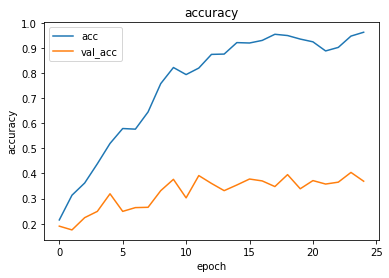

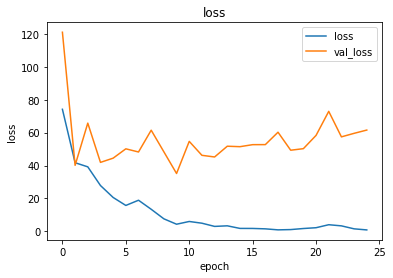

In [10]:
hist = np.load('hist/hist.npy',allow_pickle='TRUE').item()
plt.figure(0)
plt.title('accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.legend(['acc','val_acc'])
plt.savefig('models/cnn/hist_acc.png')

plt.figure(1)
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(['loss','val_loss'])
plt.savefig('models/cnn/hist_loss.png')
plt.show()